In [2]:
import numpy as np
import pandas as pd
from math import exp, pi, log
import math
import scipy.integrate as integrate
from scipy.special import iv
from scipy.optimize import brentq as root
import scipy.special as scp
import random
from collections import Counter
import time
from matplotlib import pyplot as plt

# 1) von mises packages

##  - <b><font color =red>dvonmises</font></b> 

In [ ]:
def d_vonmises(x, mu, kappa, log = False):
    if (type(x) != list):
        x=[x]
    pdf = np.zeros(len(x))
    if (log):
        if (kappa < 100000):
            pdf = -(np.log(2*math.pi)+np.log(scp.ive(0, kappa)) + kappa) + kappa*(np.cos(np.subtract(x - mu)))
        else:
            if (((x-mu)%(2*math.pi))==0):
                pdf = math.inf
            else:
                pdf = -math.inf
    else:
        if (kappa == 0):
            pdf = np.repeat(1/(2*np.pi), len(x))
        elif (kappa < 100000):
            pdf = 1/(2 * np.pi * scp.ive(0, kappa)) * (np.exp(np.subtract(np.cos(np.subtract(x, mu)), 1)))**kappa
        else:
            if (np.mod(np.subtract(x, mu),(2*np.pi))==0):
                pdf = math.inf
            else:
                pdfm = 0
    return(pdf)

In [3]:
d_vonmises(1,1,6)

array([0.95498257])

In [4]:
%timeit d_vonmises(1,1,6)

22.4 µs ± 607 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


##  - <b><font color =red>qvonmises</font></b> 

In [5]:
def q_vonmises(p, mu = 0 ,  kappa = None, from_ = None, tol = np.finfo(float).eps**0.6):
       
    if (type(p) != list):
        p = np.array([p])
    else:
        p = np.array(p)
        
    epsilon = 10 * np.finfo(float).eps  
    
    if (np.any(p > 1) or np.any(p < 0)): 
        raise ValueError("p must be between [0,1]")
        
    if (pd.isnull(from_)): 
        from_ = mu - np.pi
   
    n = len(p)
    mu = (mu - from_)%(2 * np.pi)      ## from is a keyword    
    
    if (len([mu]) != 1): 
        raise ValueError("is implemented only for scalar mean")   
        
    if (pd.isnull(kappa)): 
        raise ValueError("kappa should be provided")   
        
        
    def zeroPvonmisesRad(x, p, mu, kappa):
        if (np.isnan(x)):         
            y = np.nan              
        else: 
            integration = integrate.quad(lambda x: d_vonmises(x, mu, kappa), 0, x)
            y = integration[0] - p         ##integration[0] will give the value
        return(y);
    
    
    value = np.repeat(np.nan, p.size)
    for i in range(p.size):
        try:
            value[i] = root(lambda x: zeroPvonmisesRad(x, p[i], mu, kappa), 0, 2 * np.pi - epsilon)
        except:
            pass
            if(p[i] < (10 * epsilon)):
                value[i] = 0
            elif (p[i] > (1 - 10 * epsilon)):
                value[i] = 2 * np.pi - epsilon         
    value += from_
    return(value)


In [6]:
q_vonmises(0.5,1,6)

array([1.])

In [7]:
%timeit q_vonmises(0.5,1,6)

6.36 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


##  - <b><font color =red>pvonmises</font></b> 

In [8]:
def p_vonmises(q, mu, kappa, tol = 1e-020):
    from_ = mu - np.pi
    mu = (mu - from_) % (2 * np.pi)
    
    
    if (type(q) != list):
        q = [q]
    q = np.mod(np.subtract(q, from_), (2 * np.pi))
    q = np.mod(q,(2 * np.pi))
    n = len(q)
    mu = mu % (2 * np.pi)
    def fn_mu0(q,kappa,tol):
        flag = 1
        p = 1
        sum_ = 0
        while(flag):
            term = (iv(p, kappa) * np.sin(np.multiply(q, p)))/p
            sum_ = sum_ + term
            p = p + 1
            if (abs(term) < tol):
                flag = 0
        return(np.divide(q,(2 * np.pi)) + sum_/(np.pi * iv(0, kappa)))
    result = np.repeat(np.nan, n)
    if (mu == 0):
        for i in range(0,n):
            result[i] = fn_mu0(q[i], kappa, tol)
    else:
        for i in range(0,n):
            if (q[i] <= mu):
                upper = (q[i] - mu) % (2 * np.pi)
                if (upper == 0):
                    upper = 2 * np.pi
                lower = (-mu) % (2 * np.pi)
                result[i] = fn_mu0(upper, kappa, tol) - fn_mu0(lower, kappa, tol)
            else:
                upper = q[i] - mu
                lower = mu % (2 * np.pi)
                result[i] = fn_mu0(upper, kappa, tol) + fn_mu0(lower, kappa, tol)
    return(result)

In [9]:
p_vonmises([2,0.8],2,6)

array([0.5       , 0.00359546])

In [10]:
%timeit p_vonmises([2,0.8],2,6)

811 µs ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


##  - <b><font color =red>rvonmises</font></b> 

In [11]:
def r_vonmises(n,mu,kappa):
    a = np.random.uniform(0,1,n)
    b = [q_vonmises(x,mu,kappa) for x in a]
    c = np.squeeze([l.tolist() for l in b])
    return(np.array([a%(2*np.pi) for a in c]))

In [12]:
rv_ls = r_vonmises(50,10,3)
n=50

In [13]:
rv_ls

array([4.05752156, 3.72651472, 3.21683235, 3.62234232, 3.10097733,
       5.307654  , 4.18315263, 3.93021328, 3.89124276, 3.73603842,
       3.70065205, 3.0956978 , 2.94923353, 3.0877887 , 3.64949895,
       4.11728601, 3.04066142, 3.53525028, 2.89795636, 4.08907201,
       3.31435366, 4.14313508, 3.833729  , 3.460851  , 3.91388736,
       3.77237122, 4.38711192, 3.9422773 , 2.66760772, 3.83181341,
       3.82068698, 3.27193547, 3.65592065, 1.97232908, 3.22437948,
       4.55924725, 2.80503065, 3.7523203 , 3.30924851, 2.53762013,
       2.98845834, 3.95535685, 3.76365309, 4.93240599, 3.6583562 ,
       3.64527361, 4.09713436, 3.7081493 , 3.46610429, 4.3636981 ])

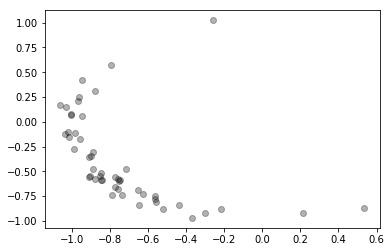

In [14]:
a = (np.cos(rv_ls)+ np.random.normal(scale=0.05,size=n))
b = (np.sin(rv_ls)+ np.random.normal(scale=0.05,size=n))
plt.plot(a, b,'o', color='black',alpha=0.3)

# 2) Mixture Distributions of von mises Fisher

### a) Method 1 - Only p=2 von mises distribution (input - angles) 

In [15]:
a=list(range(1,11))
b=list(range(11,21))
dat_ls=[math.atan(b/a) for a,b in (list(zip(a,b)))]


In [26]:
c=[10,15,20,25,100,110,120,130,140]


In [27]:
dat_ls = [x*pi/180 for x in c]
dat_ls

[0.17453292519943295,
 0.2617993877991494,
 0.3490658503988659,
 0.4363323129985824,
 1.7453292519943295,
 1.9198621771937625,
 2.0943951023931953,
 2.2689280275926285,
 2.443460952792061]

In [28]:
dat_vector = [[math.cos(x),math.sin(x)] for x in dat_ls]
p=len(dat_vector[0])
dat_vector

[[0.984807753012208, 0.17364817766693033],
 [0.9659258262890683, 0.25881904510252074],
 [0.9396926207859084, 0.3420201433256687],
 [0.9063077870366499, 0.42261826174069944],
 [-0.1736481776669303, 0.984807753012208],
 [-0.3420201433256687, 0.9396926207859084],
 [-0.4999999999999998, 0.8660254037844387],
 [-0.6427876096865394, 0.766044443118978],
 [-0.7660444431189779, 0.6427876096865395]]

In [29]:

knum = 2
n = len(dat_ls)
mu=[1,0.5]
kappa=[10,10]
p_i = [0.3,0.7] 

In [30]:
def vmf_pdf(x, mu, kappa, log = False):
    if (type(x) == int):
        x = [x]
    if (type(x) == float):
        x = [x]
    vm = np.zeros(len(x))
    if (log):
        if (kappa == 0):
            vm = np.log(np.repreat(1/(2*pi), len(x)))
        elif (kappa < 100000):
            vm = -(np.log(2*math.pi)+np.log(scp.ive(0, kappa)) + kappa) + kappa*(np.cos(np.subtract(x - mu)))
        else:
            if (((x-mu)%(2*math.pi))==0):
                vm = math.inf
            else:
                vm = -math.inf
    else:
        if (kappa == 0):
            vm = np.repeat(1/(2*np.pi), len(x))
        elif (kappa < 100000):
            vm = 1/(2 * np.pi * scp.ive(0, kappa)) * (np.exp(np.subtract(np.cos(np.subtract(x, mu)), 1)))**kappa
        else:
            if (np.mod(np.subtract(x, mu),(2*np.pi))==0):
                vm = math.inf
            else:
                vm = 0
    return(vm)


In [31]:
def comp_fn(mu,p_i,x,k,kappa):
    return p_i[k]*vmf_pdf(x,mu[k],kappa[k])

In [32]:
def Ez_fun(mu,p_i,x,k,kappa):
    return comp_fn(mu,p_i,x,k,kappa)/sum(list(map(lambda k:comp_fn(mu,p_i,x,k,kappa) ,list(range(0,knum)) )))

In [33]:
Ez_vals = np.full([n,knum], np.nan) 
for iter in range(1,100):
  # E-step
    for k in range(0,knum):
        Ez_vals[:,k] = list(map(lambda x:Ez_fun(mu,p_i,x,k,kappa) ,dat_ls )) #P(pi of which fn dat came from/parameters)
  
  # M-step
    for k in range(0,knum):
        
        #alpha
        nk = sum(Ez_vals[:,k]) 
        p_i[k] = nk/n
        
        sum_norm = np.linalg.norm(sum(map(lambda x,y:np.dot(x,y),Ez_vals[:,k],dat_vector)))
        mu_vector = sum(map(lambda x,y:np.dot(x,y),Ez_vals[:,k],dat_vector))/sum_norm 
        print("mu_vector",mu_vector)
        mu[k] = math.acos(mu_vector[0])
        print("mean",k,mu[k])
        R = sum_norm / nk
        mle_kappa = (R * (p - R**2)) / (1 - R**2)
        print("kappa",k,mle_kappa)
        kappa[k] = mle_kappa 
        print("aplha",p_i[k])
   

mu_vector [-0.4627027   0.88651351]
mean 0 2.0518377944241166
kappa 0 7.154749326566947
aplha 0.5667937188763258
mu_vector [0.94552575 0.32554732]
mean 1 0.3315905275108676
kappa 1 14.290144587449703
aplha 0.43320628112367426
mu_vector [-0.49980778  0.86613635]
mean 0 2.094173161053582
kappa 0 17.137754068370015
aplha 0.5556763861075763
mu_vector [0.95372122 0.30069226]
mean 1 0.30541842161514465
kappa 1 105.89001413314838
aplha 0.4443236138924237
mu_vector [-0.5        0.8660254]
mean 0 2.0943951000472683
kappa 0 17.27233930632456
aplha 0.555555556827218
mu_vector [0.95371695 0.3007058 ]
mean 1 0.30543261876478234
kappa 1 105.93122163965427
aplha 0.4444444431727819
mu_vector [-0.5        0.8660254]
mean 0 2.0943951003710164
kappa 0 17.27233949250356
aplha 0.5555555566516758
mu_vector [0.95371695 0.3007058 ]
mean 1 0.3054326188103176
kappa 1 105.93122161427699
aplha 0.4444444433483242
mu_vector [-0.5        0.8660254]
mean 0 2.094395100371017
kappa 0 17.272339492503747
aplha 0.55555555

kappa 1 105.9312216142795
aplha 0.4444444433483244
mu_vector [-0.5        0.8660254]
mean 0 2.094395100371017
kappa 0 17.272339492503747
aplha 0.5555555566516756
mu_vector [0.95371695 0.3007058 ]
mean 1 0.3054326188103176
kappa 1 105.9312216142795
aplha 0.4444444433483244
mu_vector [-0.5        0.8660254]
mean 0 2.094395100371017
kappa 0 17.272339492503747
aplha 0.5555555566516756
mu_vector [0.95371695 0.3007058 ]
mean 1 0.3054326188103176
kappa 1 105.9312216142795
aplha 0.4444444433483244
mu_vector [-0.5        0.8660254]
mean 0 2.094395100371017
kappa 0 17.272339492503747
aplha 0.5555555566516756
mu_vector [0.95371695 0.3007058 ]
mean 1 0.3054326188103176
kappa 1 105.9312216142795
aplha 0.4444444433483244
mu_vector [-0.5        0.8660254]
mean 0 2.094395100371017
kappa 0 17.272339492503747
aplha 0.5555555566516756
mu_vector [0.95371695 0.3007058 ]
mean 1 0.3054326188103176
kappa 1 105.9312216142795
aplha 0.4444444433483244
mu_vector [-0.5        0.8660254]
mean 0 2.094395100371017
ka

In [34]:
mu[0],mu[1],kappa[0],kappa[1],p_i[0],p_i[1]

(2.094395100371017,
 0.3054326188103176,
 17.272339492503747,
 105.9312216142795,
 0.5555555566516756,
 0.4444444433483244)

### b)  Method 2 - Generalised von mises fischer (Inputs are vectors or any N-dimensional Data) 

> <b>Either one of the following 3 cells containing Simulated data is to be run for different kind of input data</b>

>> <b>3 mixtures of 2 features</b>

In [29]:
c = [[x,y] for x,y in zip(list(np.random.normal(100,20,500)) , list(np.random.normal(50,20,500)))]

d = [[x,y] for x,y in zip(list(np.random.normal(50,10,1000)) , list(np.random.normal(0,10,1000)))]

e = [[x,y] for x,y in zip(list(np.random.normal(50,10,750)) , list(np.random.normal(100,20,750)))]

dat_raw = c+d+e

main_df = pd.DataFrame(dat_raw,columns=['feature-1','feature-2'])

>> <b>2 mixtures of 2 features</b>

In [3]:
c = [[x,y] for x,y in zip(list(np.random.normal(100,20,500)) , list(np.random.normal(50,20,500)))]

d = [[x,y] for x,y in zip(list(np.random.normal(50,10,1000)) , list(np.random.normal(0,10,1000)))]

dat_raw = c+d

main_df = pd.DataFrame(dat_raw,columns=['feature-1','feature-2'])

>> <b>2 mixtures of 3 features</b>

In [4]:
c = [[x,y,z] for x,y,z in zip(list(np.random.normal(100,20,500)) , list(np.random.normal(50,20,500)),list(np.random.normal(50,10,500)))]

d = [[x,y,z] for x,y,z in zip(list(np.random.normal(50,10,1000)) , list(np.random.normal(0,10,1000)),list(np.random.normal(100,20,1000)))]

dat_raw = c+d

main_df = pd.DataFrame(dat_raw,columns=['feature-1','feature-2','feature-3'])

In [30]:
dat_raw

[[95.3244770611635, 18.6407812714259],
 [93.66646283623787, 30.489326983364894],
 [95.70108474753349, 60.36517983296906],
 [77.36006539387901, 54.6388732104835],
 [96.54666677480043, 46.26689387701006],
 [95.59172190304406, 26.576721868641457],
 [74.31565780278459, 91.40699503209734],
 [113.76037329137641, 46.99447882632123],
 [51.13466380477551, 42.37694804252928],
 [111.2482891636834, 35.37766517113353],
 [61.936959161631364, 32.24728629725072],
 [113.95619628292638, 23.1578860921031],
 [129.87067608778406, 54.36678224160182],
 [85.5252650909024, 41.60016543378906],
 [80.25013207675423, 45.82901407516395],
 [69.42166889006808, 20.72494313628632],
 [87.43965979667024, 60.688545791488146],
 [139.63283238586507, 11.317942099183156],
 [132.2726472885717, 8.681481827546762],
 [76.18226660056087, 54.27907733440083],
 [129.83911840344098, 26.362426862845638],
 [101.66681840202854, 48.495027331588666],
 [117.1394247314898, 42.34526006269514],
 [98.31295321806837, 71.94161239732895],
 [88.123

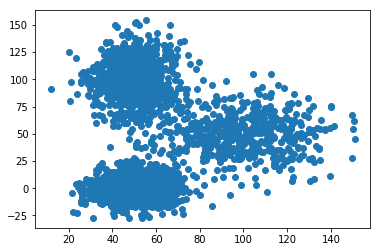

In [31]:
plt.scatter([a[0] for a in dat_raw],[a[1] for a in dat_raw])

In [32]:

def unit_vec_fn(ls):
    """Convert the list of raw n-dimensional data into
    a list of set of unit vectors 
    """    
    magnitude  = pow(sum([a**2 for a in ls]),0.5)
    unit_vector  = [c/magnitude for c in ls]
    return(unit_vector)

dat_ls = [unit_vec_fn(a) for a in dat_raw]

p=len(dat_ls[0])
dat_ls

[[0.9814113910340238, 0.19191581891199702],
 [0.9508915439806415, 0.30952426655451726],
 [0.8457984415663944, 0.5335025737930966],
 [0.8168098026573394, 0.5769070516841324],
 [0.9017980124810051, 0.43215777753652546],
 [0.9634568938358062, 0.2678634236327534],
 [0.630835336656096, 0.7759167339515175],
 [0.9242427960606557, 0.38180525655100805],
 [0.7699607005502277, 0.6380913097732976],
 [0.9529740750101361, 0.3030518311420927],
 [0.8869818201853426, 0.46180434240129925],
 [0.9799696447328364, 0.1991469191381033],
 [0.922435136042006, 0.3861520682259334],
 [0.8992628838886852, 0.4374085797743399],
 [0.8683745798202552, 0.49590885162698495],
 [0.9582112315302149, 0.28606159436273265],
 [0.821517132930758, 0.5701838302698764],
 [0.9967311401336706, 0.08079006305130038],
 [0.9978530729783929, 0.06549232586782949],
 [0.8144247359332878, 0.5802692043353623],
 [0.9800037247953953, 0.19897914309583165],
 [0.9025768584732371, 0.4305287615811308],
 [0.9404386594272535, 0.3399634213480481],
 [0.

In [33]:
def _get_vmf_likelihood_term(x, mu, kappa):
    """returns the likelihood back to the function 'vmf_pdf2()' that calculates the pdf"""
    return exp(kappa * np.dot(mu, x))

In [34]:
def _get_vmf_normalization_numerator(p, kappa): 
    """returns a part of the numerator of the pdf back to the function 'vmf_pdf2()' that calculates the pdf"""
    return kappa ** (0.5*p - 1)

In [35]:
def _get_vmf_normalization_denom(p, kappa):
    """returns a part of the denominator of the pdf back to the function 'vmf_pdf2()' that calculates the pdf"""
    return (2 * pi) ** (0.5*p) * iv(0.5*p-1, kappa)

In [36]:
def vmf_pdf2(x, mu, kappa):
    """
    Pdf of the von Mises-Fisher distribution
    Parameters:
        mu: list, location parameter
        kappa: float/int, scale parameter. Large values of kappa corresponds to lower variance
    Returns:
        list, pdf function
    """
    p=len(dat_ls[0])
    likelihood = _get_vmf_likelihood_term(x, mu, kappa)
    normalization_numerator = _get_vmf_normalization_numerator(p, kappa)
    normalization_denominator = _get_vmf_normalization_denom(p, kappa)
    return likelihood * (normalization_numerator / normalization_denominator)

In [37]:

def comp_fn(mu,p_i,x,k,kappa):
    """Numerator of the Expectation step in the algorithm and thiis function
    returns to the call from 'Ez_fun()' """
    return p_i[k]*vmf_pdf2(x,mu[k],kappa[k])


In [ ]:
def Ez_fun(mu,p_i,x,k,kappa):
    """Performs the Expectation step in the EM algorithm"""
    return comp_fn(mu,p_i,x,k,kappa)/sum(list(map(lambda k:comp_fn(mu,p_i,x,k,kappa) ,list(range(0,knum)) )))

In [38]:

t1= time.time()
knum = 3

n = len(dat_ls)
mu=[[0.5,0.5],[0.5,0.5],[0.5,0.5]]

kappa=[20,30,30]
p_i = [0.22,0.33,0.45] #[1/2,1/2]

mu_list=[]
pi_list=[]
kappa_list=[]

Ez_vals = np.full([n,knum], np.nan) 
for iter in range(1,500):
    print(kappa)
  # Expectation (E-step)
    for k in range(0,knum):
        """Performs the Expectation step in the EM algorithm for each data set of points"""
        Ez_vals[:,k] = list(map(lambda x:Ez_fun(mu,p_i,x,k,kappa) ,dat_ls )) #P(pi of which fn dat came from/parameters)

  # Maximization Step (M-step)
    for k in range(0,knum):
        
        #alpha
        nk = sum(Ez_vals[:,k]) 
        p_i[k] = nk/n
        # print(Ez_vals[:,k])
#         sum_norm = np.linalg.norm(nk)
        sum_norm = np.linalg.norm(sum(map(lambda x,y:np.dot(x,y),Ez_vals[:,k],dat_ls)))
        mu[k]= sum(map(lambda x,y:np.dot(x,y),Ez_vals[:,k],dat_ls))/sum_norm 

        #print("mean",k,mu[k])
        R = sum_norm / nk
        mle_kappa = (R * (p - R**2)) / (1 - R**2)
        #print("kappa",k,mle_kappa)
        kappa[k] = mle_kappa 
        #print("aplha",p_i[k])

 
    mu_copy = []
    mu_copy = mu.copy()
    mu_list.append(mu_copy)

    pi_copy = []
    pi_copy = p_i.copy()
    pi_list.append(pi_copy)

    kappa_copy = []
    kappa_copy = kappa.copy()
    kappa_list.append(kappa_copy)

    if(iter!=1):
        summ = 0
        for i in range(0,knum):
            summ = summ + sum([abs(a-b) for a,b in zip(np.squeeze(mu_list).tolist()[-1][i],np.squeeze(mu_list).tolist()[-1][i])]) +abs(pi_list[-1][i]-pi_list[-2][i]) +abs(kappa_list[-1][i]-kappa_list[-2][i])
        if(summ < 0.00001):
            itrn = iter
            break   
            
for i in range(0,knum):
    print("mean %s is:"%(i),list(mu[i]))
    print("kappa %s is: %s"%(i,kappa[i]))
    print("proportion %s is: %s"%(i,p_i[i]))  
t2=time.time()
print("time :",t2-t1)


    

[20, 30, 30]
[4.59441966280867, 7.284481900183474, 7.284481900183576]
[4.713560651585678, 6.613141841081929, 6.613141841081784]
[4.796138854115853, 7.598493930095134, 7.598493930094797]
[4.898675543141822, 10.757159997927669, 10.75715999792765]
[5.10105242690865, 20.847648521029335, 20.847648521027814]
[5.600289271500151, 54.22380568696903, 54.223805686963274]
[6.782447378678587, 100.51082835010097, 100.51082835013206]
[8.389977337901424, 114.51683902247699, 114.51683902251163]
[9.68993677354458, 109.79274070581023, 109.79274070581023]
[10.541346196594995, 102.35365052155306, 102.35365052156459]
[11.068411496629189, 96.79606742765061, 96.79606742766501]
[11.382047287252604, 93.25180610855757, 93.25180610856522]
[11.56259029670994, 91.12044253267624, 91.12044253267076]
[11.66462899203168, 89.87640601187213, 89.87640601181447]
[11.721877116709216, 89.16265140391775, 89.16265140385138]
[11.753926121153109, 88.75727882661256, 88.75727882657105]
[11.77186208312616, 88.52841736529632, 88.528